In [1]:
import sys
sys.path.append('..')
import os

import numpy as np
import random
import pandas as pd
import glob
import matplotlib.pyplot as plt
import networkx as nx
import copy
import time

from DAGDatasetGenerator import DAGDatasetGenerator

In [2]:
def topology_to_adjacency_matrix(filepath: str, max_node_count: int):
    df_report = pd.read_csv(filepath)

    nodes_count = len(df_report['node_id'])

    # Extract and generate input data

    # Rebuild adjacency matrix
    adj_matrix = np.zeros((max_node_count, max_node_count))

    for current_id, neighbors in enumerate(df_report['neighbors']):
        neighbors_list_str = neighbors.split(';')
        for neighbor in neighbors_list_str:
            neighbor_id = int(neighbor.split(':')[0])
            link_quality = float(neighbor.split(':')[1])
            adj_matrix[current_id][neighbor_id] = link_quality
            adj_matrix[neighbor_id][current_id] = link_quality

    return adj_matrix

In [3]:
adj_matrix = topology_to_adjacency_matrix("topologies_2024-11-14 10_06_42.792100_simulation.csv", 20)

FileNotFoundError: [Errno 2] No such file or directory: 'topologies_2024-11-14 10_06_42.792100_simulation.csv'

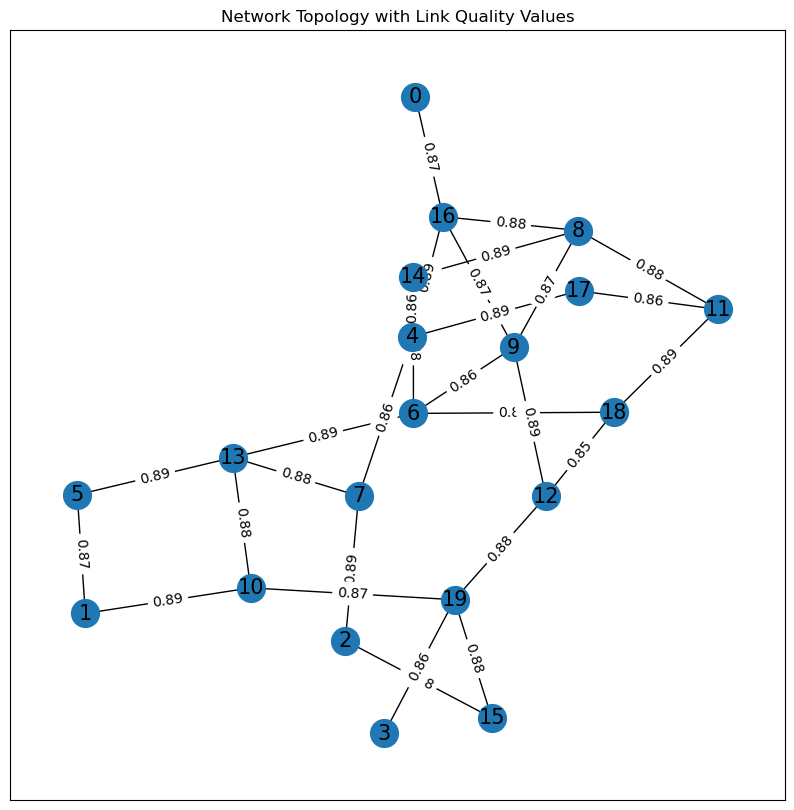

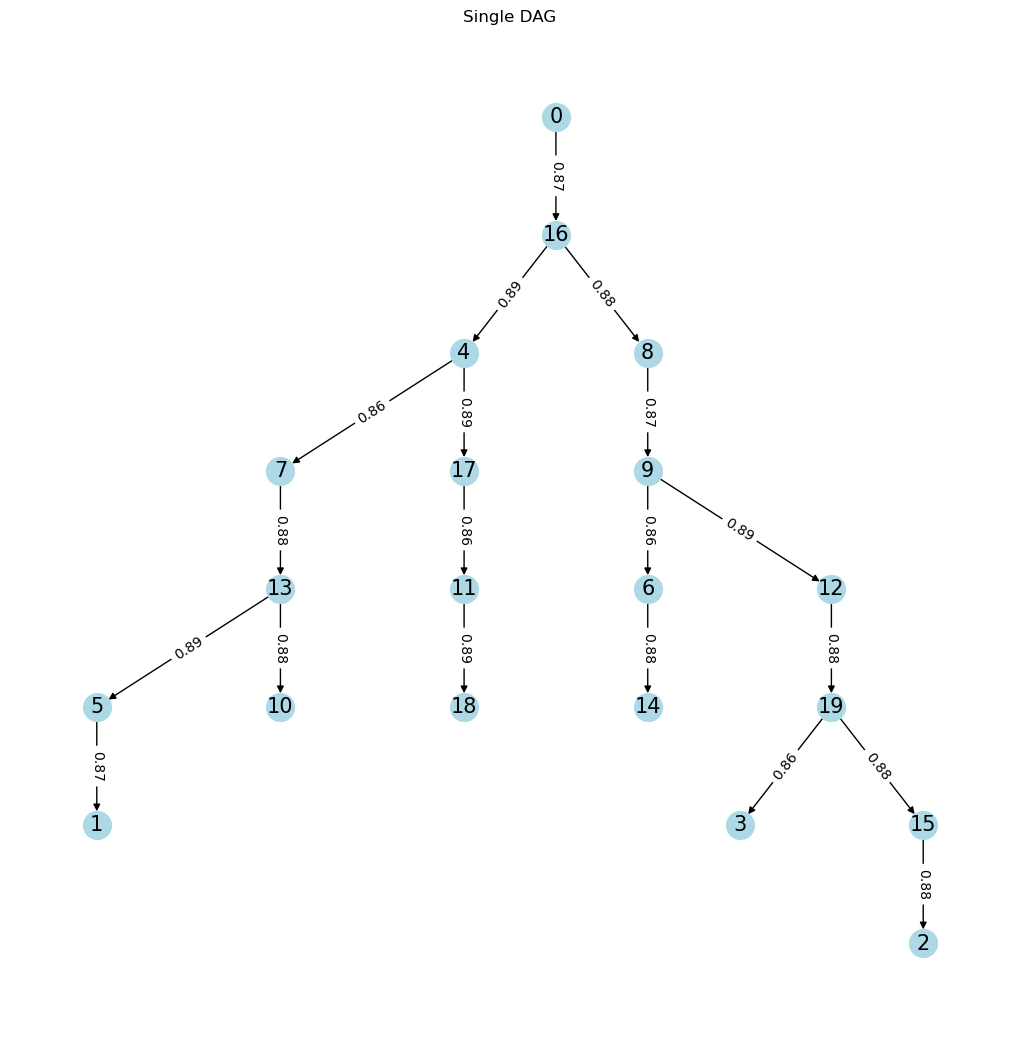

All dags 0
1235


In [ ]:
generator = DAGDatasetGenerator()

generator.draw_network(adj_matrix)

all_dags = []
all_dags = generator.generate_subset_dags_pure_c(adj_matrix, no_skip=False)
best_dag, best_perf = generator.get_best_dag_parallel_with_adaptative_steps_double_flux_pure_c(all_dags, adj_matrix, int(os.cpu_count()), False)

G = nx.DiGraph()
G.add_edges_from(best_dag)


generator.draw_dag(G, adj_matrix)

print(f"All dags {len(all_dags)}")
print(best_perf)

1429


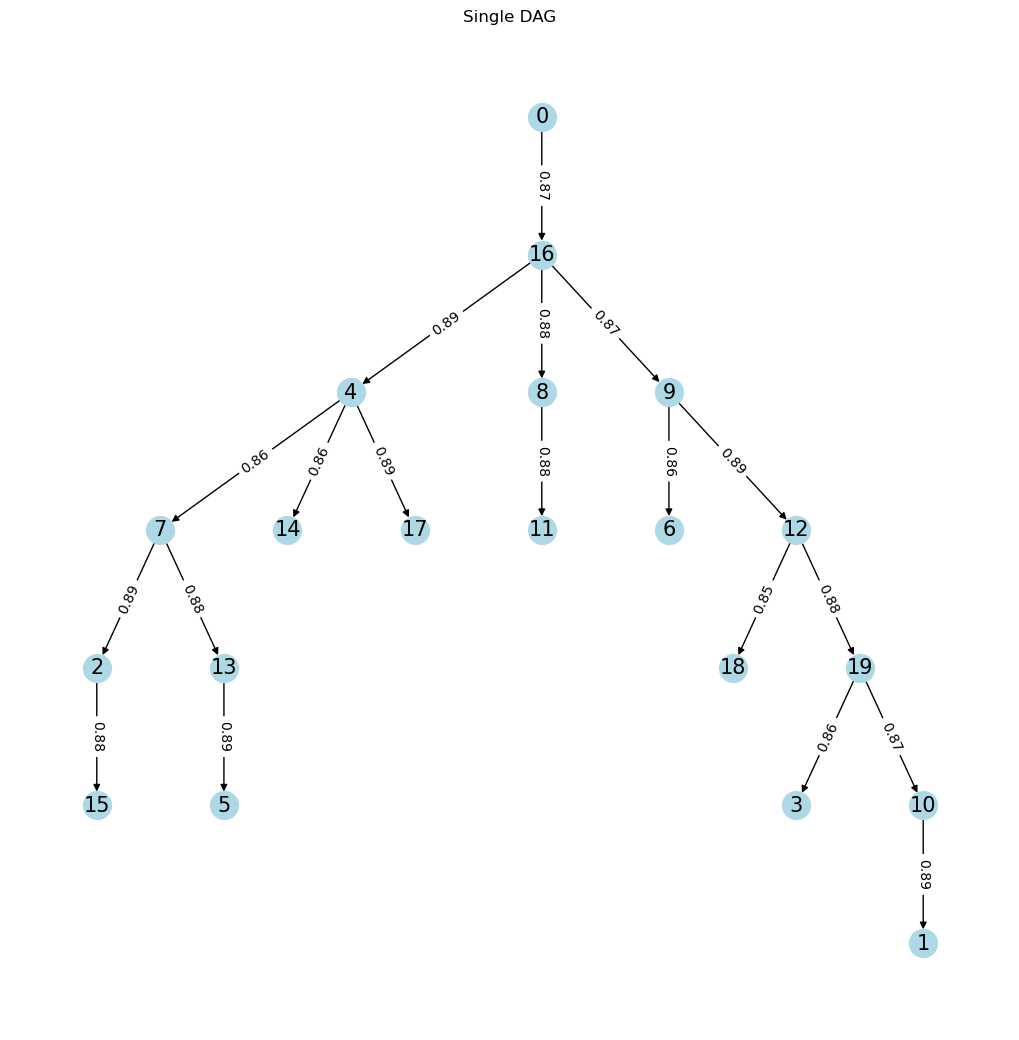

In [ ]:
emu_dag = [(0, 16), (16, 4), (4, 7), (7, 2), (2, 15), (7, 13), (13, 5), (4, 14), (4, 17), (16, 8), (8, 11), (16, 9), (9, 6), (9, 12), (12, 18), (12, 19), (19, 3), (19, 10), (10, 1)]

for dag in all_dags:
    if set(dag) == set(emu_dag):
        print("EQUAL")

_, perf = generator.evaluate_dag_performance_double_flux_pure_c(emu_dag, adj_matrix, 10, 15, -1)
print(perf)

G = nx.DiGraph()
G.add_edges_from(emu_dag)
generator.draw_dag(G, adj_matrix)

In [ ]:
# Compare up/down and double flux

all_dags = []
all_dags = generator.generate_subset_dags_pure_c(adj_matrix, no_skip=False)
all_dags_ref = copy.deepcopy(all_dags)

best_dag_double_flux, best_perf_double_flux = generator.get_best_dag_parallel_with_adaptative_steps_double_flux_pure_c(all_dags, adj_matrix, int(os.cpu_count()), False)
all_dags = copy.deepcopy(all_dags_ref)
best_dag_up_down, best_perf_up_down = generator.get_best_dag_parallel_with_adaptative_steps_pure_c(all_dags, adj_matrix, int(os.cpu_count()), False)
_, best_perf_up, best_perf_down = generator.evaluate_dag_performance_combined_pure_c(best_dag_up_down, adj_matrix, 10, 15)
best_perf_up_down = best_perf_up + best_perf_down

# cross validation

_, best_perf_up_down_cross = generator.evaluate_dag_performance_double_flux_pure_c(best_dag_up_down, adj_matrix, 10, 15)
_, best_perf_double_flux_cross_up, best_perf_double_flux_cross_down = generator.evaluate_dag_performance_combined_pure_c(best_dag_double_flux, adj_matrix, 10, 15)

best_perf_double_flux_cross = best_perf_double_flux_cross_up + best_perf_double_flux_cross_down

print(f"best_perf_double_flux {best_perf_double_flux}, best_perf_double_flux_cross {best_perf_double_flux_cross}")
print(f"best_perf_up_down {best_perf_up_down}, best_perf_up_down_cross {best_perf_up_down_cross}")

Max steps = 612
Max steps = 639

Computing best DAG in parallel took 0.64 seconds
Info: best DAG UP rank = 729/1576 (perf 592) and best DAG DOWN rank = 285/1576 (perf 623) compared to overall best score
best_perf_double_flux 1232, best_perf_double_flux_cross 1271
best_perf_up_down 1686, best_perf_up_down_cross 1585


In [4]:
generator = DAGDatasetGenerator()

#adj_matrix, density_factor = generator.generate_random_adj_matrix(20)

#np.savetxt("adj_matrix.txt", adj_matrix)

adj_matrix = np.loadtxt("adj_matrix.txt")


all_dags = generator.generate_subset_dags_pure_c(adj_matrix, test_mode=True)
print(len(all_dags))

45387


In [5]:
all_dags_copy = copy.deepcopy(all_dags)
total_time = 0
for _ in range(10):
    start_time = time.time()
    best_dag, best_perf = generator.get_best_dag_parallel_with_adaptative_steps_double_flux_pure_c(all_dags_copy, adj_matrix, int(os.cpu_count()), False)
    total_time += time.time() - start_time
    all_dags_copy = copy.deepcopy(all_dags)
print(total_time)

78.28443121910095
